In [1]:
# Custom Imports
from CircuitCollection import CircuitCollection as cc
from CircuitCollection import CircuitDataset as cd
# from CircuitCollection import CircuitCollection2
from model.Environments import CutEnvironment
import model.Utils as utils
import model.ActorCritic as models
import matplotlib.pyplot as plt
# jupyter inline plotting
from rl_main import run_model
import datetime
%matplotlib inline

# Qiskit Imports
from qiskit import *
from qiskit.transpiler import CouplingMap
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Other Imports
import itertools
import time
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf

## Data Representation
Other works (like [this](https://iopscience.iop.org/article/10.1088/2632-2153/ac28dd)) use an "image" based representation. I will use a similar one.
* each gate will be one column of "pixels"
* 1 indicates that the corresponding qubit is involved with the gate, 0 means that there are no gates on that qubit           

#### Creating Circuit Collection

In [ ]:
#####################
# Run this to generate new circuit collection
#####################
filename = "./data/4_qubits_2_depth_10_trials.p" # file to save circuit collection to

# start timer
start_time = time.time()

# Initialize a 4 qubit circuit
n = 4
depth = 2
trials = 10
gates = [(0, 1), (1, 2), (2, 3), (0, 2), (1, 3), (0, 3)] # full gateset of cnots

# circuit collection
circol = cc(gates, n, depth)

# generate all children
circol.generate_circuits()

# build all circuits
circol.build_circuits()

# transpile all circuits
circol.transpile_circuits(n = 20, trials = trials, coupling_map = CouplingMap.from_line(n), optimization_level=1)

# print run time
print("--- Total: %s seconds ---" % (time.time() - start_time))

# print circuits per second
print("--- %s circuits per second ---" % (circol.num_circuits() * trials/(time.time() - start_time)))

pickle.dump(circol, open(filename, "wb"))

In [ ]:
#####################
# Run this to load a previously generated circuit collection
#####################
filename = "../../qcircml_code/data/circol_test.p" # file to load circuit collection 

# load circuit collection
circol = pickle.load(open(filename, "rb"))

# retrieve parameters
n = circol.num_qubits
depth = circol.depth

# print parameters
print("Circuit Collection Paramters:")
print("n = " + str(n))
print("depth = " + str(depth))

#### Computing Best Cuts

In [ ]:
# Compute best cut for each circuit

optimal_circuits = []
optimal_cuts = []

for j in range(len(circol.circuits[-1])): # loop through max lenght circuits
    ind = circol.child_indecies(len(circol.circuits) - 1, j) # compute children indecies
    depths = [circol.q_transpiled[n1][n2].depth() for n1, n2 in ind]
    min = depths[np.argmin(depths)]
    min_indexes = np.where(np.array(depths) == min)[0]

    optimal_circuits.append([ind[i] for i in min_indexes]) # choose child with lowest depth

    # compute the index of the cut gate
    parent_gates = circol.circuits[-1][j]
    child_gates = [circol.circuits[optimal_circuits[-1][i][0]][optimal_circuits[-1][i][1]] for i in range(len(optimal_circuits[-1]))]

    temp = []
    for gate in parent_gates:
        b = False

        # check if gate is a best cut
        for child_list in child_gates:
            if gate not in child_list:
                b = True
                break

        if b:
            temp.append(parent_gates.index(gate))
        
    optimal_cuts.append(temp)

# draw a random circuit with the optimal cut
print()
print(optimal_cuts)

test = 8
n1, n2 = optimal_circuits[test]
print(circol.q_transpiled[-1][test].draw())
print(circol.q_transpiled[n1][n2].draw())
print(f"Depth difference: {-circol.q_transpiled[n1][n2].depth() + circol.q_transpiled[-1][test].depth()}")


<div class = "alert alert-danger"> FIXME: add some statistics </div>

<div class = "alert alert-danger"> FIXME: https://ekamperi.github.io/machine%20learning/2021/01/13/python-decorators-and-tf-function.html </div>



#### Explanation of Actor-Critic 
* https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic
* https://arshren.medium.com/unlocking-the-secrets-of-actor-critic-reinforcement-learning-a-beginners-guide-3c5953b13551

In [ ]:
# load circuit collection
circol = pickle.load(open("../qcircml_code/data/circol_test.p", "rb"))

# generate images
circol.convert_to_images()

circol = pickle.dump(circol, open("../qcircml_code/data/circol_test.p", "wb"))

For some reason adding the tf.function decorator causes the model to not converge (does no better than random)
* this is likely due to the face that the tf.function generator compiles the code into a graph which does not allow for the random number generator to be used properly
* it could also be due to some parameters not changing properly during training

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../qcircml_code/logs/ --host=127.0.0.1

In [ ]:
print([0] * 3)

In [ ]:
from model.ActorCritic import CutterPointer, Attention
import tensorflow as tf

# testing attention layer
att = Attention(100)

batch_size = 16
num_gates = 5
lstm_width = 24
x = tf.random.uniform((batch_size, num_gates, lstm_width))
g = tf.random.uniform((batch_size, lstm_width))

print(att(x, g))

In [ ]:
from model.Utils import compute_best_cuts
from CircuitCollection import CircuitCollection as cc
import pickle

circol = pickle.load(open("../../qcircml_code/data/circol_base_4qubits_8gates_depth3_dict.p", "rb"))
print(circol.depth)
compute_best_cuts(circol, circol.depth)



In [ ]:
import tensorflow as tf

in_t = tf.RaggedTensor.from_row_lengths(values=[1, 2, 3, 4, 5, 6], row_lengths = [1, 3, 2])
a = tf.RaggedTensor.from_row_lengths(values=in_t, row_lengths = [2, 1])

print(a)

b = tf.gather(a, [1, 0])

print(b)

c = tf.gather_nd(b, [[1, 1], [0, 0]])

print(c)

## Testing Circuit Dataset Structure with Utils and Environments

In [39]:
# load circuit dataset
root_dir = "../../qcircml_code/data/circset_4qubits_7gates_depth3"
circol = pickle.load(open(root_dir + "/dataset.p", "rb"))

# instantiate environment
env = CutEnvironment(circuit_dataset = circol)

# create iterator
iterator = iter(env.circol)

num = len(env.circol.current_section.train_batches)

first = env.circol.current_section.pickle_file
print(first)

# get batches
for i in range(41):
    batch = next(iterator)[0:2]

second = env.circol.current_section.pickle_file
print(second)

batch_t = tf.convert_to_tensor(batch, dtype=tf.int32)


######## Environment Testing #########

# test convert to images
images = env.convert_to_images_c(batch_t)

../../qcircml_code/data/circset_4qubits_7gates_depth3/section_0.p
../../qcircml_code/data/circset_4qubits_7gates_depth3/section_1.p


In [104]:
root_dir = "../../qcircml_code/data/circset_4qubits_7gates_depth3"
circol = pickle.load(open(root_dir + "/dataset.p", "rb"))

style = {'backgroundcolor': 'black', 'linecolor': 'white', 'textcolor': 'white'}

indecies = (1, 60)

circol.current_section.q_circuits[indecies[0]][indecies[1]].draw(output='mpl', style=style).savefig("../../child_" + str(indecies[0]) + "_" + str(indecies[1]) + ".png")

children = circol.child_indecies(indecies[0], indecies[1])

# big number
min_depth = 100000
min_child = []
for i, child in enumerate(children):
    circol.current_section.q_transpiled[child[0]][child[1]].draw(output='mpl', style=style).savefig("../../childt_" +str(i) + ".png")

    if circol.current_section.q_transpiled[child[0]][child[1]].depth() <= min_depth:
        min_depth = circol.current_section.q_transpiled[child[0]][child[1]].depth()

for child in children:
    if circol.current_section.q_transpiled[child[0]][child[1]].depth() == min_depth:
        min_child.append(children.index(child))

print(min_child)
print(min_depth)

[1, 3]
5


In [41]:
# image = images[0]
# print(image)

# imagenumpy = image.numpy()
# print(image.numpy())

# image_t = tf.convert_to_tensor(np.transpose(imagenumpy))
# print(image_t)

print(images)

print(images.to_tensor())

<tf.RaggedTensor [[[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0],
  [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]],

 [[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0],
  [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]]]>


ValueError: TypeError: object of type 'RaggedTensor' has no len()


# Comparing Models
#### Fully Connected Only

In [45]:
def old_compute_best_cuts(circol, depth: int = 2):
    optimal_circuits = []
    optimal_cuts = []

    for k in range (depth - 1):

        optimal_cuts.insert(0, [])
        optimal_circuits.insert(0, [])

        for j in range(len(circol.circuits[-1 - k])): # loop through max lenght circuits

            ind = circol.child_indecies(len(circol.circuits) - 1 - k, j) # compute children indecies
            depths = [circol.q_transpiled[n1][n2].depth() for n1, n2 in ind]
            min = depths[np.argmin(depths)]
            min_indexes = np.where(np.array(depths) == min)[0]

            optimal_circuits[0].append([ind[i] for i in min_indexes]) # choose child with lowest depth

            # compute the index of the cut gate
            parent_gates = circol.circuits[-1 - k][j]
            child_gates = [circol.circuits[optimal_circuits[0][-1][i][0]][optimal_circuits[0][-1][i][1]] for i in range(len(optimal_circuits[0][-1]))]

            temp = []

            for child_list in child_gates:
                for i in range(len(child_list)):
                    if child_list[i] != parent_gates[i]:
                        temp.append(i) ## FIXME: this works for now, but this is not guaranteed to be the exact cut index if multiple gates in a row (doens't matter now since we only care about the min depth at the validation step)
                        break

                    if i == len(child_list) - 1:
                        temp.append(i + 1)

                
            optimal_cuts[0].append(temp)


    return optimal_cuts, optimal_circuits

def old_cut(circol, circuit_batch, actions):
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    depths = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

    for i in range(len(circuit_batch)):
        state = circuit_batch[i]
        action = actions[i][0]

        # remove gate from circuit
        gates = list(circol.circuits[state[0]][state[1]])
        gates.pop(action)

        # get new state
        new_state = circol.gates_to_index(gates)

        # # compute reward (negative depth difference) (old - new)
        # NOTE: maybe later scale with max possible improvement of each circuit
        reward = circol.q_transpiled[state[0]][state[1]].depth() - circol.q_transpiled[new_state[0]][new_state[1]].depth() - 1
        reward = reward / abs(reward) * reward ** 2 if reward != 0 else 0

        rewards.write(i, reward).mark_used()
        depths.write(i, circol.q_transpiled[new_state[0]][new_state[1]].depth()).mark_used()

        # reward = self.circol.q_transpiled[self.state[0]][self.state[1]].depth() / self.circol.q_transpiled[new_state[0]][new_state[1]].depth()
        
    rewards = rewards.stack().numpy()
    depths = depths.stack().numpy()
    return rewards, depths#, self.get_image()

def convert_to_images(circol, indexes):
    images = []

    for i in range(len(indexes)):
        images.append(circol.images[indexes[i][0]][indexes[i][1]])

    return images

def old_validate(val_indexes, model, optimal_cuts):
    hist = {}
    opt_cuts_temp = []

    # convert batch to images
    images = tf.convert_to_tensor(convert_to_images(circol, val_indexes))

    # sample action from model
    action_logits_c, values = model(images)
    
    action = tf.random.categorical(action_logits_c, 1).numpy()

    # choose first cut for each list in optimal_cuts
    for i in range(len(val_indexes)):
        opt_cuts_temp.append(optimal_cuts[0][val_indexes[i][1]][0])

    # print("opt_cuts_temp:", opt_cuts_temp)
    opt_cuts_temp = tf.convert_to_tensor(opt_cuts_temp, tf.int32)
    # transpose
    opt_cuts_temp = tf.expand_dims(opt_cuts_temp, 0)
    opt_cuts_temp = tf.transpose(opt_cuts_temp)

    # print("opt_cuts_temp:", opt_cuts_temp)

    # cut circuits
    rewards, depths = old_cut(circol, val_indexes, action) # cut with chosen cuts
    rewards_opt, depths_opt = old_cut(circol, val_indexes, opt_cuts_temp) # cut with optimal cuts

    # compute difference in depth
    difference = depths - depths_opt

    # compute histogram
    for i in range(len(val_indexes)):
        if difference[i] not in hist.keys():
            hist[difference[i]] = 1
        else:
            hist[difference[i]] += 1
    
    action = action.squeeze()
    return action, difference

CWD: /Users/ahilty/Documents/git/QCutML
Folders: ['0', '1', '2', '3', '4', '5', '6', '7']
--- Generate: 0.0006248950958251953 seconds ---
--- Convert: 0.0043430328369140625 seconds ---


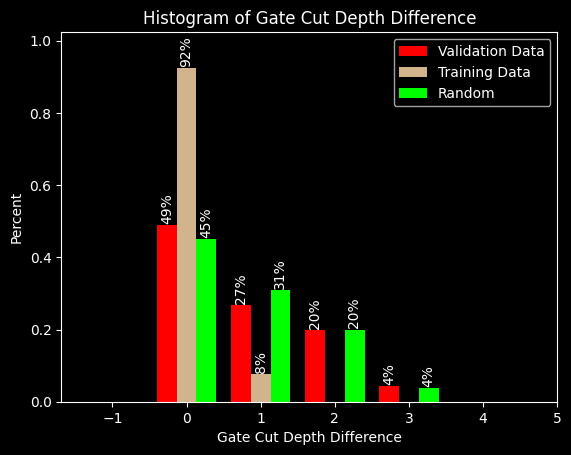

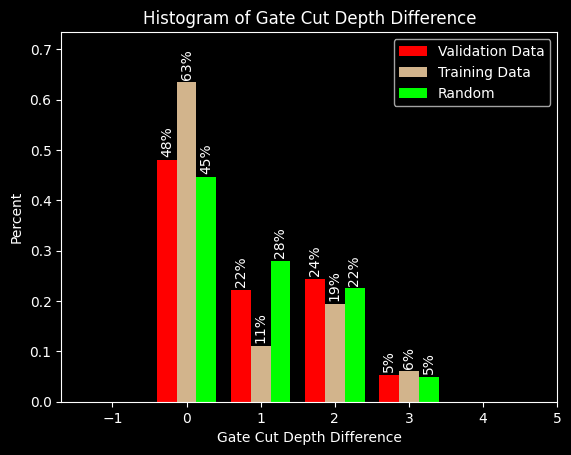

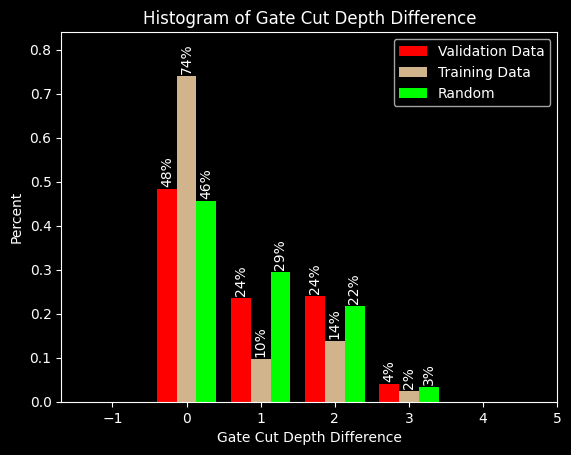

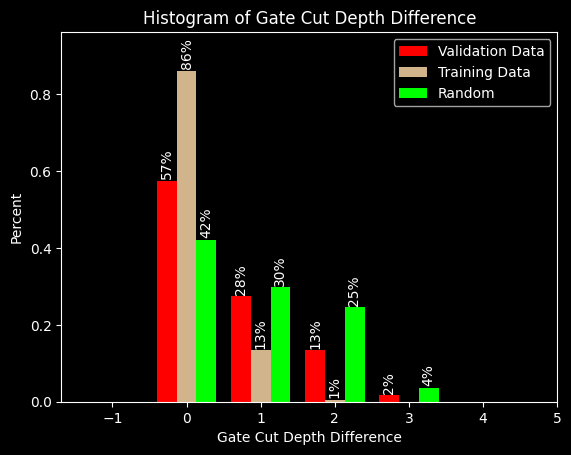

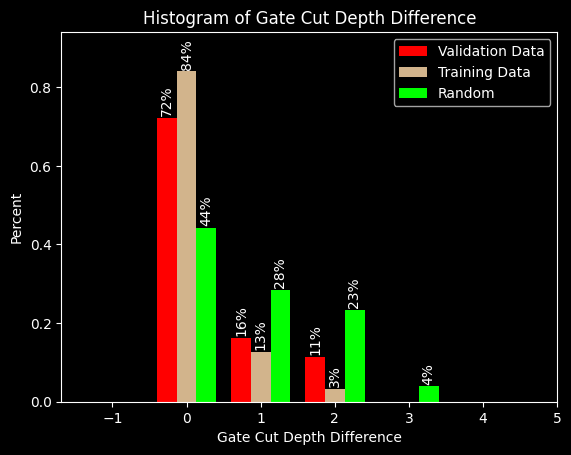

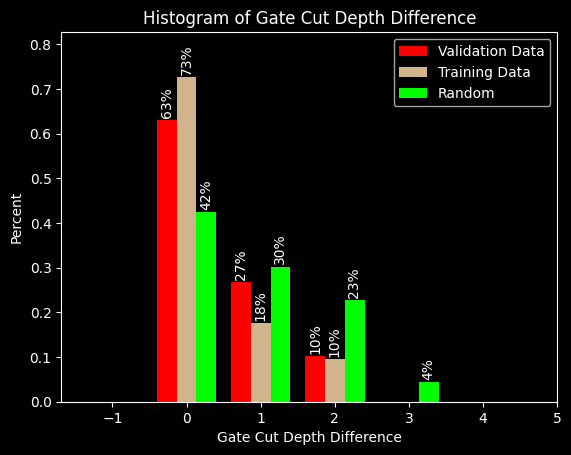

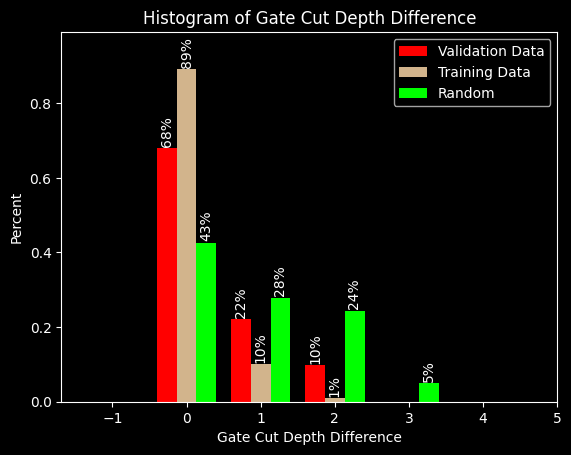

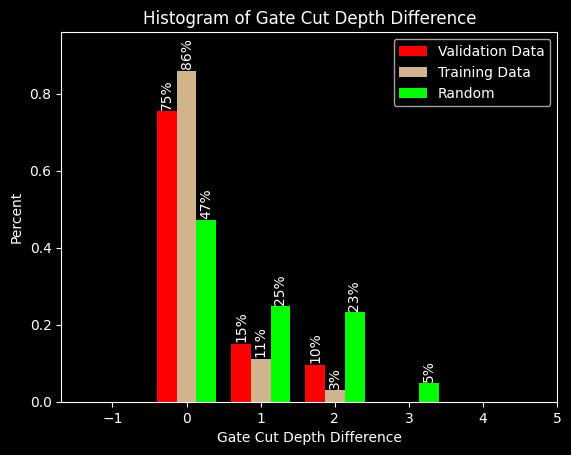

In [66]:
sweep_folder = '../../qcircml_code/data_07312023_sweep7/'
date_str = '07312023'
num_qubits = 4
circuit_collection = "4_qubits_2_depth_10_trials.p"

# print working directory
print("CWD:", os.getcwd())

# create dataframe skeleton with dictionary
df_skeleton = {
    "folder": [],
    "circ_filename": [],
    "dataset_path": [],
    "batch_size": [],
    "loops": [],
    "train_percent": [],
    "action_size": [],
    "model_type": [],
    "layer_lists": [],
    "learning_rate": [],
    "window_size": [],
    "tf_function": [],
    "hist": [],
    "validation_avg": [],
    "train_avg": [],
    "random_avg": [],
    "notes": []
}

# get list of folders in chronological order of creation (oldest first)
folders = sorted(os.listdir(sweep_folder), key=lambda x: os.path.getctime(sweep_folder + x))

# remove .DS_Store from list
folders = [x for x in folders if x != ".DS_Store" and int(x) < 10]

print("Folders:", folders)

# load circuit colleciton and get optimal depths
circol = pickle.load(open("../../qcircml_code/data/" + circuit_collection, "rb"))
circol.reps = [1, 1, 1, 1, 1, 1]
circol.circuit_indexes = {}
circol.images = []
circol.generate_circuits()
circol.convert_to_images()
optimal_cuts, optimal_depths = old_compute_best_cuts(circol)

# instantiate random agent
random_agent = models.RandomSelector(6)

# begin loop
for folder in folders:
    # constuct path to folder
    folder_path = sweep_folder + folder

    # load parameters
    param_dict = pickle.load(open(folder_path + f"/{date_str}_{folder}_parameters.p", "rb"))

    # construct new layer list from old style
    layer_list = [[('flatten', None)]]
    for i in range(len(param_dict["fc_layer_list"])):
        layer_list[0].append(("fc", param_dict["fc_layer_list"][i]))

    # instantiate model
    model = models.Cutter(param_dict["action_size"], layer_list[0], False)

    # load weights
    image_shape = (num_qubits, param_dict["action_size"])
    dummy = tf.zeros((1, image_shape[0], image_shape[1]))
        
    action_logits_c, values = model(dummy)

    model.load_weights(folder_path + f"/{date_str}_{folder}_weights_final.h5")

    # load dataset
    if param_dict["load_dataset"]:
        train_data, train_index, val_data = pickle.load(open(param_dict["dataset_filename"], "rb"))
    else:
        train_data, train_index, val_data = pickle.load(open(folder_path + f"/{date_str}_{folder}_dataset.p", "rb"))

    # validate
    a, hist = old_validate(val_data, model, optimal_cuts) # validation data 
    a, hist_t = old_validate(train_index, model, optimal_cuts)
    a, hist_r = old_validate(val_data, random_agent, optimal_cuts) # random agent
    a, hist_rt = old_validate(train_index, random_agent, optimal_cuts)
    random_full = np.concatenate((hist_r, hist_rt))

    # plot
    plot_hist = [hist, hist_t, random_full]
    # plot multi-bar histogram using hist, random_hist, hist_t, random_hist_t in matplotlib
    colors = ['red', 'tan', 'lime']
    labels = ['Validation Data', 'Training Data', 'Random']
    res = plt.hist(plot_hist, bins=range(-1, max(random_full) + 3), color=colors, label=labels, density=True, align='left')
    plt.legend()
    plt.title("Histogram of Gate Cut Depth Difference")
    plt.xlabel("Gate Cut Depth Difference")
    plt.ylabel("Percent")
    # show all x ticks
    plt.xticks(range(-1, max(random_full) + 3))

    # show percentage above each bar in histogram
    max_n = 0
    for i in range(len(res[0])):
        for j in range(len(res[1]) - 1):
            if res[0][i][j] != 0:
                plt.text(res[1][j] + (-0.36 + 0.265 * i), res[0][i][j] + 0.012, str(round(res[0][i][j] * 100)) + "%", rotation=90)
            
            if res[0][i][j] > max_n:
                max_n = res[0][i][j]

    # set y axis limit to max + text height
    plt.ylim(0, max_n + 0.1)

    plt.show()

    # compute averages
    validation_avg = np.sum(res[0][0] * res[1][:-1])
    train_avg = np.sum(res[0][1] * res[1][:-1])
    random_avg = np.sum(res[0][2] * res[1][:-1])

    # add row to skeleton
    df_skeleton["folder"].append(folder_path)
    df_skeleton["circ_filename"].append("4_qubits_2_depth_10_trials.p")
    df_skeleton["dataset_path"].append(param_dict["dataset_filename"] if param_dict["load_dataset"] else folder_path + f"/{date_str}_{folder}_dataset.p")
    df_skeleton["batch_size"].append(param_dict["batch_size"])
    df_skeleton["loops"].append(param_dict["loops"])
    df_skeleton["train_percent"].append(param_dict["train_percent"])
    df_skeleton["action_size"].append(param_dict["action_size"])
    df_skeleton["model_type"].append("rl")
    df_skeleton["layer_lists"].append(layer_list)
    df_skeleton["learning_rate"].append(param_dict["learning_rate"])
    df_skeleton["window_size"].append(param_dict["window_size"])
    df_skeleton["tf_function"].append(False)
    df_skeleton["hist"].append(res[0])
    df_skeleton["validation_avg"].append(validation_avg)
    df_skeleton["train_avg"].append(train_avg)
    df_skeleton["random_avg"].append(random_avg)
    df_skeleton["notes"].append(param_dict["notes"])

# make dataframe from skeleton
df = pd.DataFrame(df_skeleton)

# load master datafram
master_df = pd.read_csv("../../qcircml_code/data/master_data.csv")

# concatenate dataframes
master_df = pd.concat([master_df, df], ignore_index=True)

# save master dataframe
master_df.to_csv("../../qcircml_code/data/master_data.csv", index=False)
        


#### New Data


Validation Expectation Value: 0.4358863156677364
Training Expectation Value: 0.3021944661288924
Random Expectation Value: 1.9140515222482435
Train Percent: 0.1


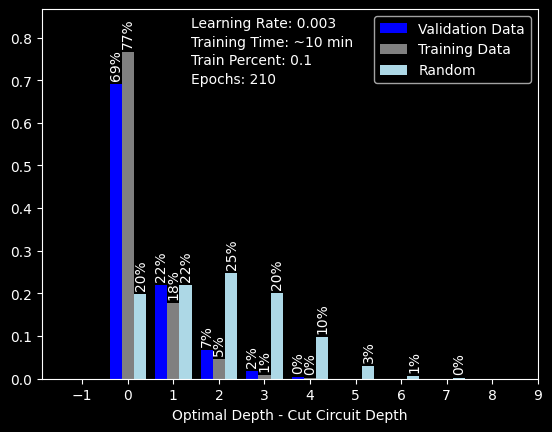


Validation Expectation Value: 0.3430975304511604
Training Expectation Value: 0.30598201636453004
Random Expectation Value: 1.9122473761818022
Train Percent: 0.30000000000000004


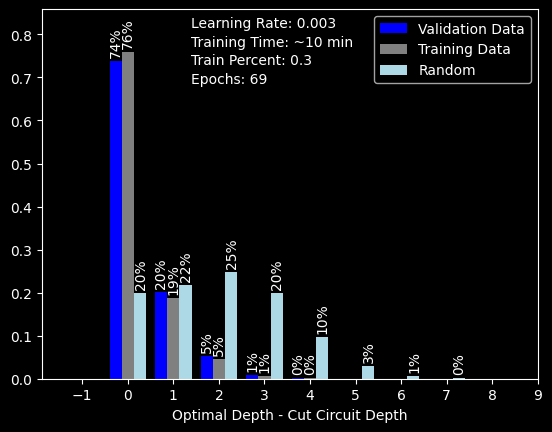


Validation Expectation Value: 0.3195767195767196
Training Expectation Value: 0.30486599011189175
Random Expectation Value: 1.9145199063231852
Train Percent: 0.5


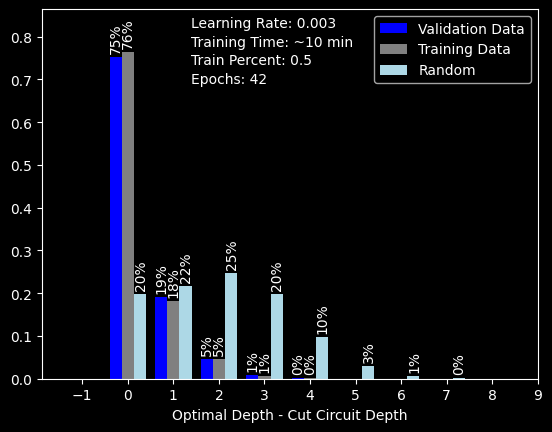


Validation Expectation Value: 0.32567149507040216
Training Expectation Value: 0.316642503996134
Random Expectation Value: 1.9148148148148145
Train Percent: 0.7


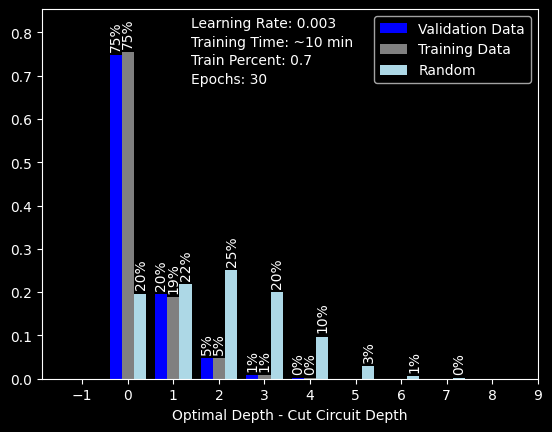


Validation Expectation Value: 0.3467776910399861
Training Expectation Value: 0.33269725619452395
Random Expectation Value: 1.9157602567438632
Train Percent: 0.9


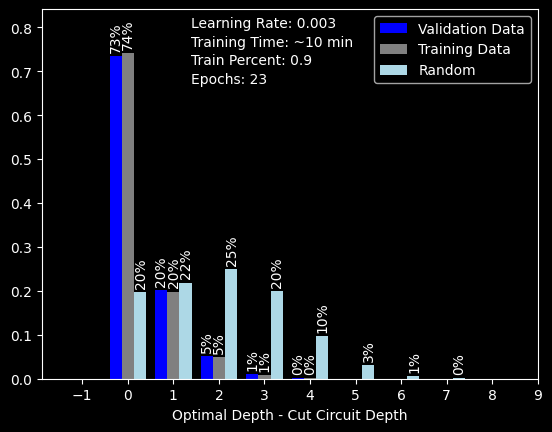

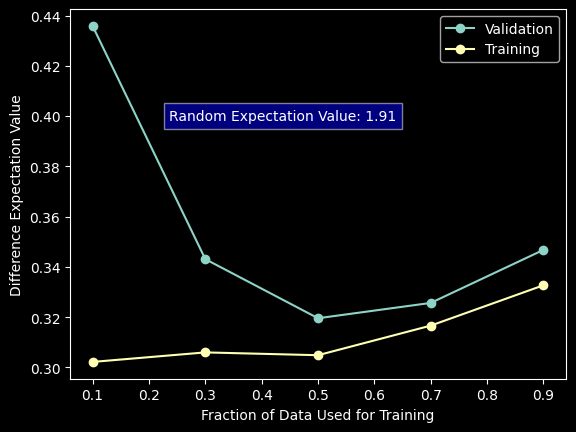

In [159]:
date_str = '08232023'
sweep_num = 4
sweep_folder = f'../../qcircml_code/data_{date_str}_sweep{str(sweep_num)}/'
num_qubits = 4

folder_list = [2, 3, 4, 12, 6]
samples = 1000


val_exp_list = []
train_exp_list = []
random_exp_list = []
train_percent_list = []
for fol_num in folder_list:
    folderoot = sweep_folder + str(fol_num) + '/'

    # load histogram txt
    hist = np.loadtxt(folderoot + f'{date_str}_{str(fol_num)}_hist_model0.txt')

    # compute expectation values
    val_exp = np.sum(hist[0] * np.arange(-1, len(hist[0]) - 1))
    train_exp = np.sum(hist[1] * np.arange(-1, len(hist[1]) - 1))
    random_exp = np.sum(hist[2] * np.arange(-1, len(hist[2]) - 1))

    # append to list
    val_exp_list.append(val_exp)
    train_exp_list.append(train_exp)
    random_exp_list.append(random_exp)

    # print values
    print(f'\nValidation Expectation Value: {val_exp}')
    print(f'Training Expectation Value: {train_exp}')
    print(f'Random Expectation Value: {random_exp}')

    # load parameters
    param_dict = pickle.load(open(folderoot + f'{date_str}_{str(fol_num)}_parameters.p', 'rb'))
    train_percent_list.append(param_dict['train_percent'])
    print(f'Train Percent: {param_dict["train_percent"]}')

    # sample distribution
    diffs = []
    for i in range(len(hist)):
        diffs.append([])
        for j in range(len(hist[i])):
            temp = np.ones(int(hist[i][j] * samples), dtype= np.int64) * (j - 1)

            diffs[i] += list(temp)

    plot_hist = diffs

    # plot multi-bar histogram using hist, random_hist, hist_t, random_hist_t in matplotlib
    colors = ['blue', 'grey', 'lightblue']
    labels = ['Validation Data', 'Training Data', 'Random']
    res = plt.hist(plot_hist, bins=range(-1, max(diffs[-1]) + 3), color=colors, label=labels, density=True, align='left')

    # add model metadata on plot
    plt.text(0.3, 0.95, f'Learning Rate: {0.003}', transform=plt.gca().transAxes)
    plt.text(0.3, 0.9, f'Training Time: ~{10} min', transform=plt.gca().transAxes)
    plt.text(0.3, 0.85, f'Train Percent: {round(train_percent_list[-1], 2)}', transform=plt.gca().transAxes)
    plt.text(0.3, 0.8, f'Epochs: {param_dict["loops"]}', transform=plt.gca().transAxes)


    plt.legend()
    plt.xlabel("Optimal Depth - Cut Circuit Depth")
    # plt.ylabel("Percent")
    # show all x ticks
    plt.xticks(range(-1, max(diffs[-1]) + 3))

    # show percentage above each bar in histogram
    max_n = 0
    for i in range(len(res[0])):
        for j in range(len(res[1]) - 1):
            if res[0][i][j] != 0:
                plt.text(res[1][j] + (-0.42 + 0.275 * i), res[0][i][j] + 0.016, str(round(res[0][i][j] * 100)) + "%", rotation=90)
            
            if res[0][i][j] > max_n:
                max_n = res[0][i][j]

    # set y axis limit to max + text height
    plt.ylim(0, max_n + 0.1)
    plt.show()

# plot expectation values marking points with shapes
plt.plot(train_percent_list, val_exp_list, label='Validation', marker='o')
plt.plot(train_percent_list, train_exp_list, label='Training', marker='o')

# add random expection value as text box
plt.text(0.2, 0.7, f'Random Expectation Value: {round(random_exp_list[0],2)}', transform=plt.gca().transAxes, bbox=dict(facecolor='blue', alpha=0.5))

plt.xlabel('Fraction of Data Used for Training')
plt.ylabel('Difference Expectation Value')

plt.legend()

    

In [ ]:
def old_compute_best_cuts(circol, depth: int = 2):
    optimal_circuits = []
    optimal_cuts = []

    for k in range (depth - 1):

        optimal_cuts.insert(0, [])
        optimal_circuits.insert(0, [])

        for j in range(len(circol.circuits[-1 - k])): # loop through max lenght circuits

            ind = circol.child_indecies(len(circol.circuits) - 1 - k, j) # compute children indecies
            depths = [circol.q_transpiled[n1][n2].depth() for n1, n2 in ind]
            min = depths[np.argmin(depths)]
            min_indexes = np.where(np.array(depths) == min)[0]

            optimal_circuits[0].append([ind[i] for i in min_indexes]) # choose child with lowest depth

            # compute the index of the cut gate
            parent_gates = circol.circuits[-1 - k][j]
            child_gates = [circol.circuits[optimal_circuits[0][-1][i][0]][optimal_circuits[0][-1][i][1]] for i in range(len(optimal_circuits[0][-1]))]

            temp = []

            for child_list in child_gates:
                for i in range(len(child_list)):
                    if child_list[i] != parent_gates[i]:
                        temp.append(i) ## FIXME: this works for now, but this is not guaranteed to be the exact cut index if multiple gates in a row (doens't matter now since we only care about the min depth at the validation step)
                        break

                    if i == len(child_list) - 1:
                        temp.append(i + 1)

                
            optimal_cuts[0].append(temp)


    return optimal_cuts, optimal_circuits

def old_cut(circol, circuit_batch, actions):
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    depths = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

    for i in range(len(circuit_batch)):
        state = circuit_batch[i]
        action = actions[i][0]

        # remove gate from circuit
        gates = list(circol.circuits[state[0]][state[1]])
        gates.pop(action)

        # get new state
        new_state = circol.gates_to_index(gates)

        # # compute reward (negative depth difference) (old - new)
        # NOTE: maybe later scale with max possible improvement of each circuit
        reward = circol.q_transpiled[state[0]][state[1]].depth() - circol.q_transpiled[new_state[0]][new_state[1]].depth() - 1
        reward = reward / abs(reward) * reward ** 2 if reward != 0 else 0

        rewards.write(i, reward).mark_used()
        depths.write(i, circol.q_transpiled[new_state[0]][new_state[1]].depth()).mark_used()

        # reward = self.circol.q_transpiled[self.state[0]][self.state[1]].depth() / self.circol.q_transpiled[new_state[0]][new_state[1]].depth()
        
    rewards = rewards.stack().numpy()
    depths = depths.stack().numpy()
    return rewards, depths#, self.get_image()

def convert_to_images(circol, indexes):
    images = []

    for i in range(len(indexes)):
        images.append(circol.images[indexes[i][0]][indexes[i][1]])

    return images

def old_validate(val_indexes, model, optimal_cuts):
    hist = {}
    opt_cuts_temp = []

    # convert batch to images
    images = tf.convert_to_tensor(convert_to_images(circol, val_indexes))

    # sample action from model
    action_logits_c, values = model(images)
    
    action = tf.random.categorical(action_logits_c, 1).numpy()

    # choose first cut for each list in optimal_cuts
    for i in range(len(val_indexes)):
        opt_cuts_temp.append(optimal_cuts[0][val_indexes[i][1]][0])

    # print("opt_cuts_temp:", opt_cuts_temp)
    opt_cuts_temp = tf.convert_to_tensor(opt_cuts_temp, tf.int32)
    # transpose
    opt_cuts_temp = tf.expand_dims(opt_cuts_temp, 0)
    opt_cuts_temp = tf.transpose(opt_cuts_temp)

    # print("opt_cuts_temp:", opt_cuts_temp)

    # cut circuits
    rewards, depths = old_cut(circol, val_indexes, action) # cut with chosen cuts
    rewards_opt, depths_opt = old_cut(circol, val_indexes, opt_cuts_temp) # cut with optimal cuts

    # compute difference in depth
    difference = depths - depths_opt

    # compute histogram
    for i in range(len(val_indexes)):
        if difference[i] not in hist.keys():
            hist[difference[i]] = 1
        else:
            hist[difference[i]] += 1
    
    action = action.squeeze()
    return action, difference


Validation Expectation Value: 0.4358863156677364
Training Expectation Value: 0.3021944661288924
Random Expectation Value: 1.9140515222482435
Train Percent: 0.1


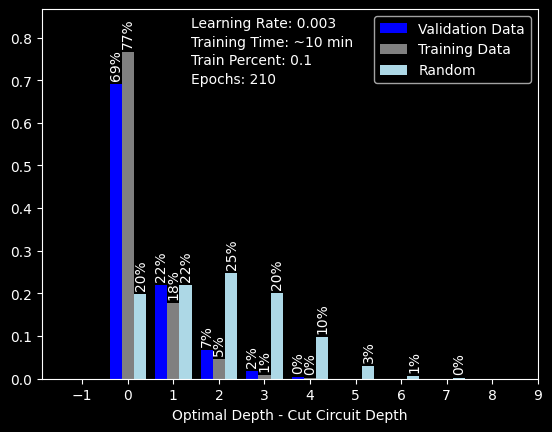

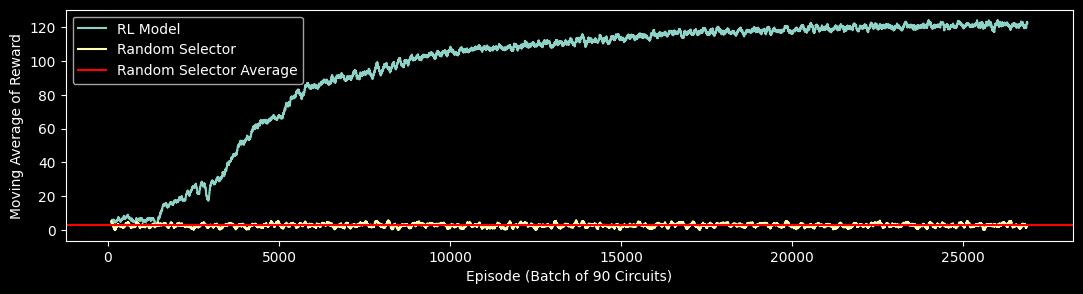


Validation Expectation Value: 0.3430975304511604
Training Expectation Value: 0.30598201636453004
Random Expectation Value: 1.9122473761818022
Train Percent: 0.30000000000000004


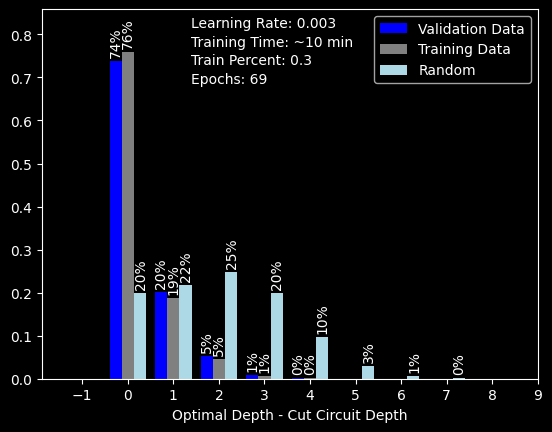

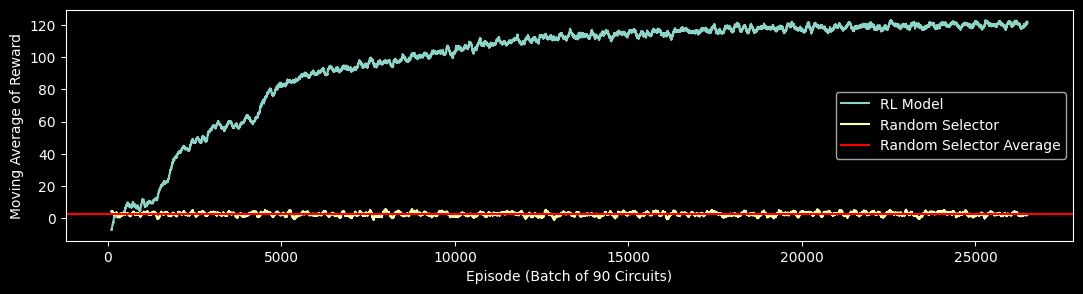


Validation Expectation Value: 0.3195767195767196
Training Expectation Value: 0.30486599011189175
Random Expectation Value: 1.9145199063231852
Train Percent: 0.5


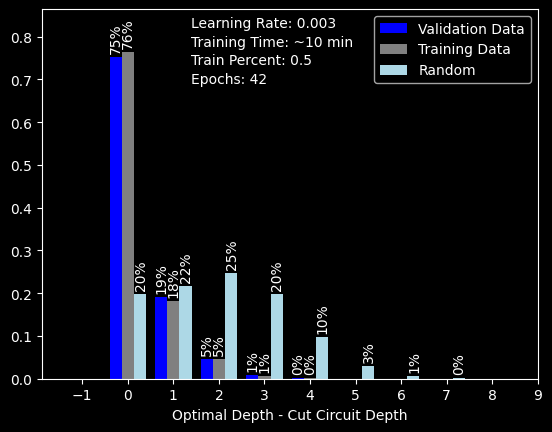

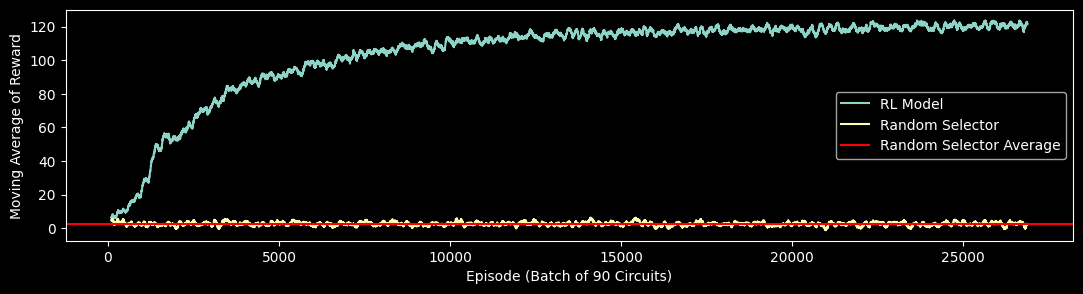


Validation Expectation Value: 0.32567149507040216
Training Expectation Value: 0.316642503996134
Random Expectation Value: 1.9148148148148145
Train Percent: 0.7


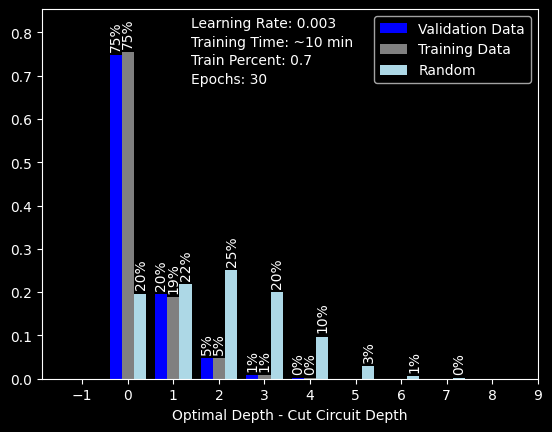

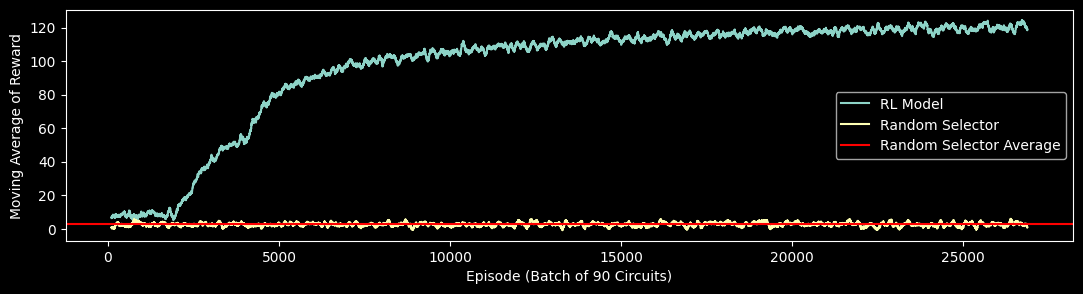


Validation Expectation Value: 0.3467776910399861
Training Expectation Value: 0.33269725619452395
Random Expectation Value: 1.9157602567438632
Train Percent: 0.9


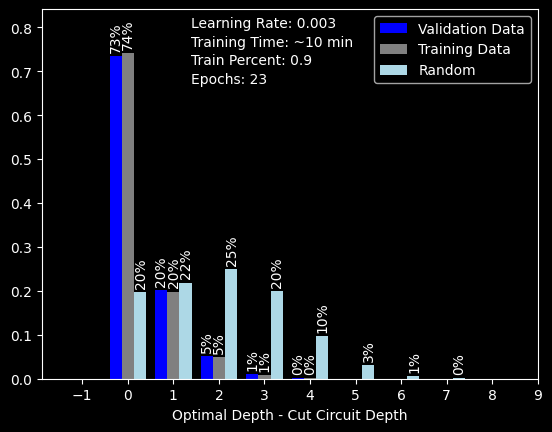

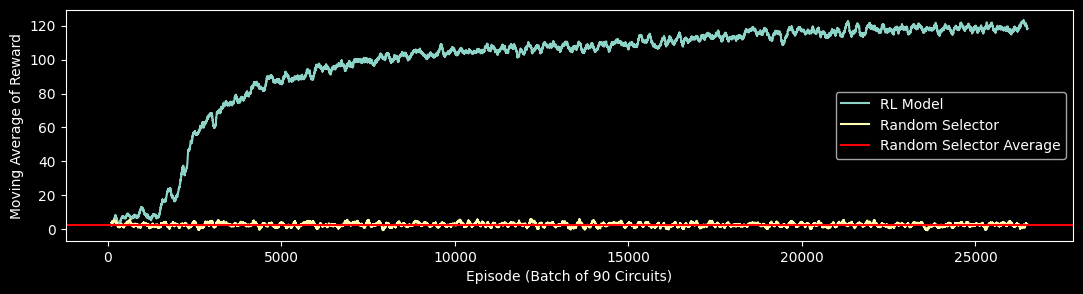

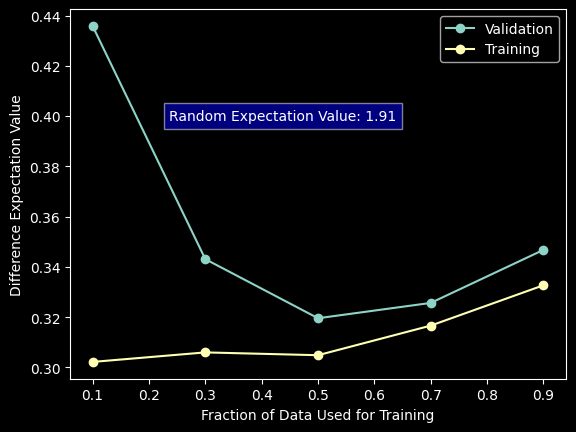

In [185]:
date_str = '08232023'
sweep_num = 4
sweep_folder = f'../../qcircml_code/data_{date_str}_sweep{str(sweep_num)}/'
num_qubits = 4

folder_list = [2, 3, 4, 12, 6]
samples = 1000


val_exp_list = []
train_exp_list = []
random_exp_list = []
train_percent_list = []
for fol_num in folder_list:
    folderoot = sweep_folder + str(fol_num) + '/'

    # load histogram txt
    hist = np.loadtxt(folderoot + f'{date_str}_{str(fol_num)}_hist_model0.txt')

    # compute expectation values
    val_exp = np.sum(hist[0] * np.arange(-1, len(hist[0]) - 1))
    train_exp = np.sum(hist[1] * np.arange(-1, len(hist[1]) - 1))
    random_exp = np.sum(hist[2] * np.arange(-1, len(hist[2]) - 1))

    # append to list
    val_exp_list.append(val_exp)
    train_exp_list.append(train_exp)
    random_exp_list.append(random_exp)

    # print values
    print(f'\nValidation Expectation Value: {val_exp}')
    print(f'Training Expectation Value: {train_exp}')
    print(f'Random Expectation Value: {random_exp}')

    # load parameters
    param_dict = pickle.load(open(folderoot + f'{date_str}_{str(fol_num)}_parameters.p', 'rb'))
    train_percent_list.append(param_dict['train_percent'])
    print(f'Train Percent: {param_dict["train_percent"]}')

    # sample distribution
    diffs = []
    for i in range(len(hist)):
        diffs.append([])
        for j in range(len(hist[i])):
            temp = np.ones(int(hist[i][j] * samples), dtype= np.int64) * (j - 1)

            diffs[i] += list(temp)

    plot_hist = diffs

    # plot multi-bar histogram using hist, random_hist, hist_t, random_hist_t in matplotlib
    colors = ['blue', 'grey', 'lightblue']
    labels = ['Validation Data', 'Training Data', 'Random']
    res = plt.hist(plot_hist, bins=range(-1, max(diffs[-1]) + 3), color=colors, label=labels, density=True, align='left')

    # add model metadata on plot
    plt.text(0.3, 0.95, f'Learning Rate: {0.003}', transform=plt.gca().transAxes)
    plt.text(0.3, 0.9, f'Training Time: ~{10} min', transform=plt.gca().transAxes)
    plt.text(0.3, 0.85, f'Train Percent: {round(train_percent_list[-1], 2)}', transform=plt.gca().transAxes)
    plt.text(0.3, 0.8, f'Epochs: {param_dict["loops"]}', transform=plt.gca().transAxes)


    plt.legend()
    plt.xlabel("Optimal Depth - Cut Circuit Depth")
    # plt.ylabel("Percent")
    # show all x ticks
    plt.xticks(range(-1, max(diffs[-1]) + 3))

    # show percentage above each bar in histogram
    max_n = 0
    for i in range(len(res[0])):
        for j in range(len(res[1]) - 1):
            if res[0][i][j] != 0:
                plt.text(res[1][j] + (-0.42 + 0.275 * i), res[0][i][j] + 0.016, str(round(res[0][i][j] * 100)) + "%", rotation=90)
            
            if res[0][i][j] > max_n:
                max_n = res[0][i][j]

    # set y axis limit to max + text height
    plt.ylim(0, max_n + 0.1)
    plt.show()

    # load csv data
    data = pd.read_csv(folderoot + f'{date_str}_{str(fol_num)}_data.csv')
    # get data past index 3 and set index 3 as column headers and remove last column
    data.columns = data.iloc[3]
    data = data.iloc[4:, :-1]

    # convert data to floates
    data = data.astype(float)

    # compute and plot moving average of both columns
    data['m_avg_model'] = data['Episode Rewards 0'][:].rolling(window=100).mean()
    data['m_avg_random'] = data['Episode Rewards 1'][:].rolling(window=100).mean()

    # plot moving average
    plt.plot(data['m_avg_model'], label='RL Model')
    plt.plot(data['m_avg_random'], label='Random Selector')

    # plot horizontal line at average of second columns
    plt.axhline(y=data['Episode Rewards 1'].mean(), color='r', linestyle='-', label='Random Selector Average')

    plt.xlabel("Episode (Batch of 90 Circuits)")
    plt.ylabel("Moving Average of Reward")

    # set figure size
    plt.gcf().set_size_inches(13, 3)

    plt.legend()
    plt.show()
    

# plot expectation values marking points with shapes
plt.plot(train_percent_list, val_exp_list, label='Validation', marker='o')
plt.plot(train_percent_list, train_exp_list, label='Training', marker='o')

# add random expection value as text box
plt.text(0.2, 0.7, f'Random Expectation Value: {round(random_exp_list[0],2)}', transform=plt.gca().transAxes, bbox=dict(facecolor='blue', alpha=0.5))

plt.xlabel('Fraction of Data Used for Training')
plt.ylabel('Difference Expectation Value')

plt.legend()


Validation Expectation Value: 0.47717928701535256
Training Expectation Value: 0.47461184838234016
Random Expectation Value: 1.9165755919854282
Train Percent: 0.1


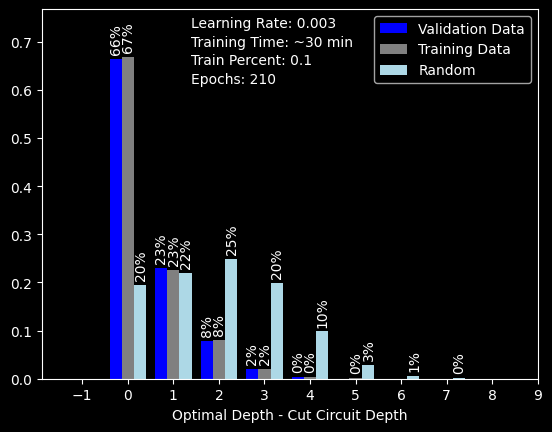

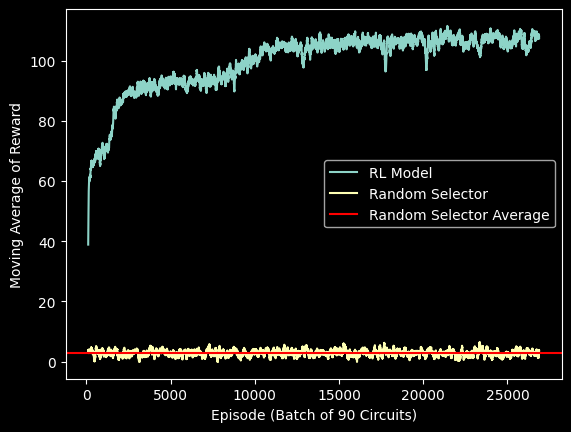


Validation Expectation Value: 0.4599705091508371
Training Expectation Value: 0.45565096712637704
Random Expectation Value: 1.9126550438025847
Train Percent: 0.5


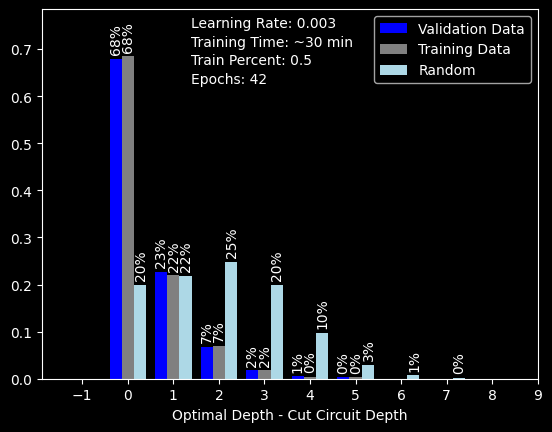

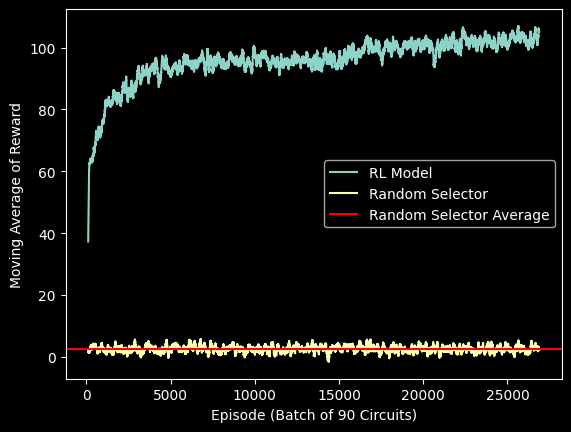


Validation Expectation Value: 0.5470841645705035
Training Expectation Value: 0.5507849770144851
Random Expectation Value: 1.9100268887154133
Train Percent: 0.7


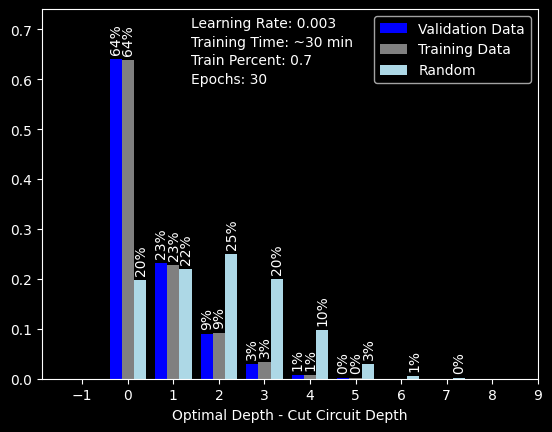

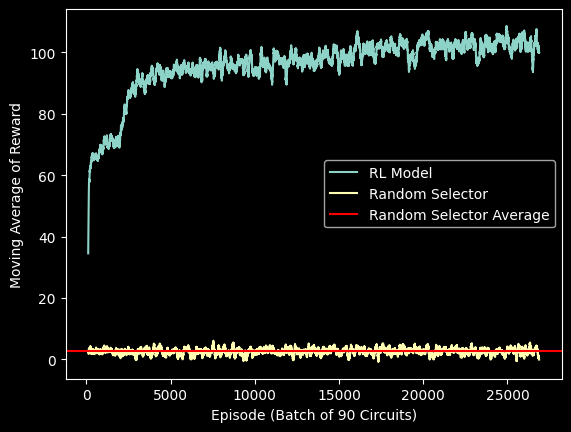


Validation Expectation Value: 0.5416775088906237
Training Expectation Value: 0.5395958018908839
Random Expectation Value: 1.915951079885506
Train Percent: 0.9


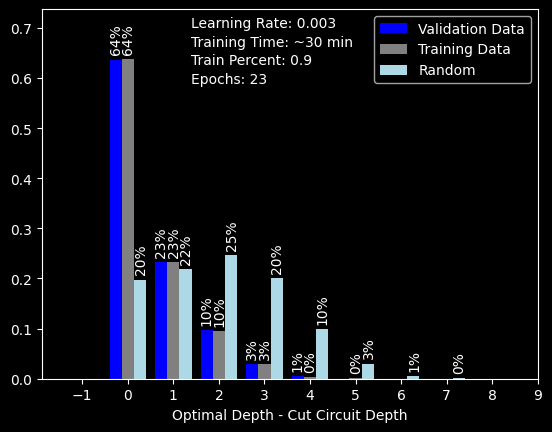

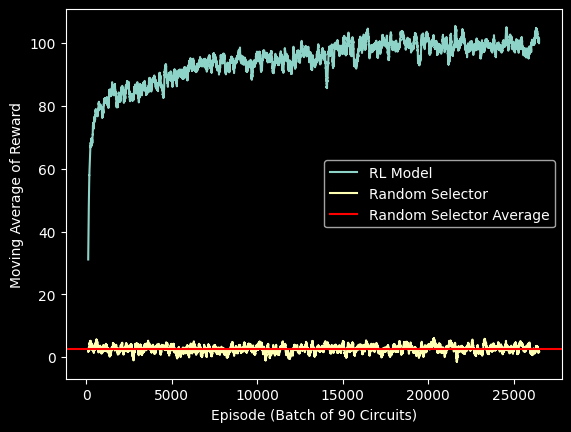

3,Episode Rewards 0,Episode Rewards 1,m_avg_model,m_avg_random
4,4.0,6.0,NaN,NaN
5,-1.0,0.0,NaN,NaN
6,3.0,0.0,NaN,NaN
7,28.0,15.0,NaN,NaN
8,-16.0,7.0,NaN,NaN
...,...,...,...,...
26494,137.0,-1.0,100.40,1.87
26495,103.0,-6.0,100.66,1.72
26496,122.0,4.0,100.79,1.77
26497,109.0,0.0,101.08,1.88


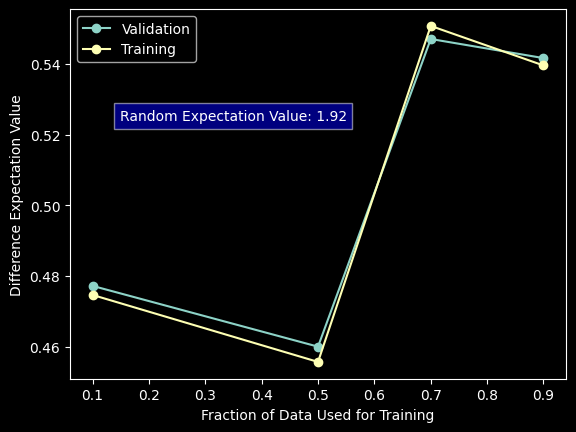

In [189]:
date_str = '08232023'
sweep_num = 5
sweep_folder = f'../../qcircml_code/data_{date_str}_sweep{str(sweep_num)}/'
num_qubits = 4

folder_list = [8, 9, 4, 7]
samples = 1000


val_exp_list = []
train_exp_list = []
random_exp_list = []
train_percent_list = []
for fol_num in folder_list:
    folderoot = sweep_folder + str(fol_num) + '/'

    # load histogram txt
    hist = np.loadtxt(folderoot + f'{date_str}_{str(fol_num)}_hist_model0.txt')

    # compute expectation values
    val_exp = np.sum(hist[0] * np.arange(-1, len(hist[0]) - 1))
    train_exp = np.sum(hist[1] * np.arange(-1, len(hist[1]) - 1))
    random_exp = np.sum(hist[2] * np.arange(-1, len(hist[2]) - 1))

    # append to list
    val_exp_list.append(val_exp)
    train_exp_list.append(train_exp)
    random_exp_list.append(random_exp)

    # print values
    print(f'\nValidation Expectation Value: {val_exp}')
    print(f'Training Expectation Value: {train_exp}')
    print(f'Random Expectation Value: {random_exp}')

    # load parameters
    param_dict = pickle.load(open(folderoot + f'{date_str}_{str(fol_num)}_parameters.p', 'rb'))
    train_percent_list.append(param_dict['train_percent'])
    print(f'Train Percent: {param_dict["train_percent"]}')

    # sample distribution
    diffs = []
    for i in range(len(hist)):
        diffs.append([])
        for j in range(len(hist[i])):
            temp = np.ones(int(hist[i][j] * samples), dtype= np.int64) * (j - 1)

            diffs[i] += list(temp)

    plot_hist = diffs

    # plot multi-bar histogram using hist, random_hist, hist_t, random_hist_t in matplotlib
    colors = ['blue', 'grey', 'lightblue']
    labels = ['Validation Data', 'Training Data', 'Random']
    res = plt.hist(plot_hist, bins=range(-1, max(diffs[-1]) + 3), color=colors, label=labels, density=True, align='left')

    # add model metadata on plot
    plt.text(0.3, 0.95, f'Learning Rate: {0.003}', transform=plt.gca().transAxes)
    plt.text(0.3, 0.9, f'Training Time: ~{30} min', transform=plt.gca().transAxes)
    plt.text(0.3, 0.85, f'Train Percent: {round(train_percent_list[-1], 2)}', transform=plt.gca().transAxes)
    plt.text(0.3, 0.8, f'Epochs: {param_dict["loops"]}', transform=plt.gca().transAxes)


    plt.legend()
    plt.xlabel("Optimal Depth - Cut Circuit Depth")
    # plt.ylabel("Percent")
    # show all x ticks
    plt.xticks(range(-1, max(diffs[-1]) + 3))

    # show percentage above each bar in histogram
    max_n = 0
    for i in range(len(res[0])):
        for j in range(len(res[1]) - 1):
            if res[0][i][j] != 0:
                plt.text(res[1][j] + (-0.42 + 0.275 * i), res[0][i][j] + 0.016, str(round(res[0][i][j] * 100)) + "%", rotation=90)
            
            if res[0][i][j] > max_n:
                max_n = res[0][i][j]

    # set y axis limit to max + text height
    plt.ylim(0, max_n + 0.1)
    plt.show()

    # load csv data
    data = pd.read_csv(folderoot + f'{date_str}_{str(fol_num)}_data.csv')
    # get data past index 3 and set index 3 as column headers and remove last column
    data.columns = data.iloc[3]
    data = data.iloc[4:, :-1]

    # convert data to floates
    data = data.astype(float)

    # compute and plot moving average of both columns
    data['m_avg_model'] = data['Episode Rewards 0'][:].rolling(window=100).mean()
    data['m_avg_random'] = data['Episode Rewards 1'][:].rolling(window=100).mean()

    # plot moving average
    plt.plot(data['m_avg_model'], label='RL Model')
    plt.plot(data['m_avg_random'], label='Random Selector')

    # plot horizontal line at average of second columns
    plt.axhline(y=data['Episode Rewards 1'].mean(), color='r', linestyle='-', label='Random Selector Average')

    plt.xlabel("Episode (Batch of 90 Circuits)")
    plt.ylabel("Moving Average of Reward")

    plt.legend()

    # plt.gcf().set_size_inches(13, 3)

    plt.show()
    

# plot expectation values marking points with shapes
plt.plot(train_percent_list, val_exp_list, label='Validation', marker='o')
plt.plot(train_percent_list, train_exp_list, label='Training', marker='o')

# add random expection value as text box
plt.text(0.1, 0.7, f'Random Expectation Value: {round(random_exp_list[0],2)}', transform=plt.gca().transAxes, bbox=dict(facecolor='blue', alpha=0.5))

plt.xlabel('Fraction of Data Used for Training')
plt.ylabel('Difference Expectation Value')

plt.legend()

data

In [9]:
# model_type = "attention"
# layer_lists = [ 80, 80, [('fc', int(700)), ('fc', int(700/2))] ]
model_type = "rl"
layer_lists = [('flatten', None), ('fc', 466), ('fc', 233)]
action_size = 9
transpose = False
model_load_filename = "../../qcircml_code/data_08232023_sweep4/4/checkpoints/08232023_4_weights_j0_final.h5"
num_qubits = 4
batch_size = 90
repetitions = int(26000/90)

model = None

if model_type == "attention":
    model = models.CutterPointer(layer_lists[0], layer_lists[1], layer_lists[2])
elif model_type == "rl":
    model = models.Cutter(action_size, layer_lists, transpose)

# load model weights
image_shape = (num_qubits, action_size)
dummy = tf.zeros((2, image_shape[0], image_shape[1]))

action_logits_c, values = model(dummy)
model.load_weights(model_load_filename)

# prepare sample image
gate_list = [(0, 1), (0, 1), (1, 2), (1, 2), (2, 3), (2, 3), (0, 2), (1, 3), (0, 3)]
image = np.zeros((action_size, num_qubits)) # initialize image
for i, gate in enumerate(gate_list):
    # NOTE: set both to one (not preservering target/ctrl qubit information for now)
    image[i][gate[0]] = 1
    image[i][gate[1]] = 1
image = np.transpose(image)
image = tf.convert_to_tensor(image, dtype = tf.float32)
batch = tf.repeat(tf.expand_dims(image, axis = 0), batch_size, axis = 0)

# run model repitions times and time it
start_time = time.time()
print(repetitions)
for i in range(repetitions):
    action_logits_c, values = model(batch)
print("--- %s seconds ---" % (time.time() - start_time))


IndexError: list index out of range